In [1]:
from datetime import date, timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
).set_index(
    ['store_nbr', 'item_nbr', 'date'])

df_train.reset_index(inplace=True)
    
df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

df_test.reset_index(inplace=True)

items = pd.read_csv(
    "items.csv",
).set_index("item_nbr")

date           0
dcoilwtico    76
dtype: int64 

Type :  
 date          datetime64[ns]
dcoilwtico           float64
dtype: object
date          0
dcoilwtico    0
dtype: int64 

Type :  
 date          datetime64[ns]
dcoilwtico           float64
dtype: object


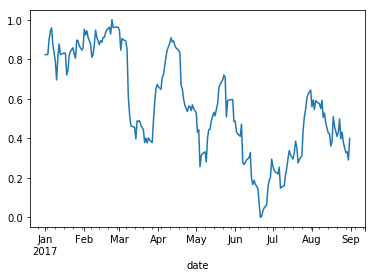

date          0
dcoilwtico    0
dtype: int64 

Type :  
 date          datetime64[ns]
dcoilwtico           float64
dtype: object


In [2]:
import datetime
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
calendar=[]
d1=datetime.datetime.strptime('2017-01-01', '%Y-%m-%d') 
d2=datetime.datetime.strptime('2017-08-31', '%Y-%m-%d')
delta=d2-d1

for i in range(delta.days+1):
    calendar.append(datetime.date.strftime(d1+timedelta(days=i), '%Y-%m-%d'))
    
calendar=pd.DataFrame({'date':calendar})
calendar['date']  = pd.to_datetime(calendar['date'])

#process the oil data
oil = pd.read_csv('oil.csv', usecols=[0,1], parse_dates=["date"] )
#use calendar df from the hols prep 

oil = calendar.merge(oil, left_on='date', right_on='date', how='left')

#Check how many NA
print(oil.isnull().sum(), '\n')
print('Type : ', '\n', oil.dtypes)

#Check index to apply the formula
na_index_oil = oil[oil['dcoilwtico'].isnull() == True].index.values

#Define the index to use to apply the formala
na_index_oil_plus = na_index_oil.copy()
na_index_oil_minus = np.maximum(0, na_index_oil-1)

for i in range(len(na_index_oil)):
    k = 1
    while (na_index_oil[min(i+k,len(na_index_oil)-1)] == na_index_oil[i]+k):
        k += 1
    na_index_oil_plus[i] = min(len(oil)-1, na_index_oil_plus[i] + k )

#Apply the formula
for i in range(len(na_index_oil)):
    if (na_index_oil[i] == 0):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_plus[i], 'dcoilwtico']
    elif (na_index_oil[i] == len(oil)):
        oil.loc[na_index_oil[i], 'dcoilwtico'] = oil.loc[na_index_oil_minus[i], 'dcoilwtico']
    else:
        oil.loc[na_index_oil[i], 'dcoilwtico'] = (oil.loc[na_index_oil_plus[i], 'dcoilwtico'] + oil.loc[na_index_oil_minus[i], 'dcoilwtico'])/ 2    

oil['dcoilwtico'].ffill (inplace=True)
oil['dcoilwtico'].bfill (inplace=True)
print(oil.isnull().sum(), '\n')
print('Type : ', '\n', oil.dtypes)
oil[['dcoilwtico']] = MinMaxScaler().fit_transform(oil[['dcoilwtico']])
#Plot the oil values
oil_plot = oil['dcoilwtico'].copy()
oil_plot.index = oil['date'].copy()
oil_plot.plot()
plt.show()
print(oil.isnull().sum(), '\n')
print('Type : ', '\n', oil.dtypes)

In [3]:
df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
df_2017=df_2017.merge(oil, left_on='date', right_on='date', how='left')
df_2017_oil=df_2017[['store_nbr', 'item_nbr', 'date', 'dcoilwtico']].copy()
print(df_2017.isnull().sum(), '\n')
print('Type : ', '\n', df_2017.dtypes)
df_oil= df_2017_oil.groupby(['store_nbr', 'item_nbr', 'date'])['dcoilwtico'].max().unstack('date')
df_oil = df_oil.apply(lambda x:x.fillna(x.value_counts().index[0]))
df_oil.columns = df_oil.columns.get_level_values(0)
df_oil = df_oil.reindex(df_oil.index).fillna(False)
df_oil.head()

store_nbr      0
item_nbr       0
date           0
unit_sales     0
onpromotion    0
dcoilwtico     0
dtype: int64 

Type :  
 store_nbr               int64
item_nbr                int64
date           datetime64[ns]
unit_sales            float64
onpromotion              bool
dcoilwtico            float64
dtype: object


date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995       0.823333    0.823333    0.823333    0.898333   
          99197       0.823333    0.823333    0.823333    0.898333   
          103520      0.823333    0.823333    0.823333    0.898333   
          103665      0.823333    0.823333    0.823333    0.898333   
          105574      0.823333    0.823333    0.823333    0.898333   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.940833    0.958333     0.87375    0.831458   
          99197       0.940833    0.958333     0.87375    0.831458   
          103520      0.940833    0.958333     0.87375    0.831458   
          103665      0.940833    0.958333     0.87375    0.831458   
          105574      0.940833    0.958333     0.87375    0.831458   

date                2017-01-09  2017-01-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995       0.789167       0.695     ...        0.578333   
          99197       0.789167       0.695     ...        0.578333   
          103520      0.789167       0.695     ...        0.578333   
          103665      0.789167       0.695     ...        0.578333   
          105574      0.789167       0.695     ...        0.578333   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       0.574167    0.549167      0.5925       0.505   
          99197       0.574167    0.549167      0.5925       0.505   
          103520      0.574167    0.549167      0.5925       0.505   
          103665      0.574167    0.549167      0.5925       0.505   
          105574      0.574167    0.549167      0.5925       0.505   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995         0.5275    0.476667     0.45125    0.425833    0.424167  
          99197         0.5275    0.476667     0.45125    0.425833    0.424167  
          103520        0.5275    0.476667     0.45125    0.425833    0.424167  
          103665        0.5275    0.476667     0.45125    0.425833    0.424167  
          105574        0.5275    0.476667     0.45125    0.425833    0.424167  

[5 rows x 227 columns]

In [4]:
df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

df_test.reset_index(inplace=True)
df_test=df_test.merge(oil, left_on='date', right_on='date', how='left')
df_oil_test=df_test[['store_nbr', 'item_nbr', 'date', 'dcoilwtico']].copy()
print(df_oil_test.isnull().sum(), '\n')
print('Type : ', '\n', df_oil_test.dtypes)
df_oil_test1= df_oil_test.groupby(['store_nbr', 'item_nbr', 'date'])['dcoilwtico'].max().unstack('date')
df_oil_test1.head()
df_oil_test1.columns = df_oil_test1.columns.get_level_values(0)
df_oil_test1 = df_oil_test1.reindex(df_oil.index).fillna(False)
df_oil_test1.head()
oil_2017 = pd.concat([df_oil, df_oil_test1], axis=1)
oil_2017.head()

store_nbr     0
item_nbr      0
date          0
dcoilwtico    0
dtype: int64 

Type :  
 store_nbr              int64
item_nbr               int64
date          datetime64[ns]
dcoilwtico           float64
dtype: object


date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995       0.823333    0.823333    0.823333    0.898333   
          99197       0.823333    0.823333    0.823333    0.898333   
          103520      0.823333    0.823333    0.823333    0.898333   
          103665      0.823333    0.823333    0.823333    0.898333   
          105574      0.823333    0.823333    0.823333    0.898333   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.940833    0.958333     0.87375    0.831458   
          99197       0.940833    0.958333     0.87375    0.831458   
          103520      0.940833    0.958333     0.87375    0.831458   
          103665      0.940833    0.958333     0.87375    0.831458   
          105574      0.940833    0.958333     0.87375    0.831458   

date                2017-01-09  2017-01-10     ...      2017-08-22  \
store_nbr item_nbr                             ...                   
1         96995       0.789167       0.695     ...        0.430833   
          99197       0.789167       0.695     ...        0.430833   
          103520      0.789167       0.695     ...        0.430833   
          103665      0.789167       0.695     ...        0.430833   
          105574      0.789167       0.695     ...        0.430833   

date                2017-08-23  2017-08-24  2017-08-25  2017-08-26  \
store_nbr item_nbr                                                   
1         96995         0.4975    0.396667    0.430833     0.37875   
          99197         0.4975    0.396667    0.430833     0.37875   
          103520        0.4975    0.396667    0.430833     0.37875   
          103665        0.4975    0.396667    0.430833     0.37875   
          105574        0.4975    0.396667    0.430833     0.37875   

date                2017-08-27  2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                              
1         96995       0.352708    0.326667    0.331667        0.29    0.398333  
          99197       0.352708    0.326667    0.331667        0.29    0.398333  
          103520      0.352708    0.326667    0.331667        0.29    0.398333  
          103665      0.352708    0.326667    0.331667        0.29    0.398333  
          105574      0.352708    0.326667    0.331667        0.29    0.398333  

[5 rows x 243 columns]

In [5]:

df_train = pd.read_csv(
    'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)
df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
#del df_train
df_test = pd.read_csv(
    "test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)

promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
#del promo_2017_test, promo_2017_train

df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)

df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))

def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_7_2017": get_timespan(promo_2017, t2017, 7, 7).sum(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_30_2017": get_timespan(promo_2017, t2017, 30, 30).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values,
        "oil_7_2017": get_timespan(oil_2017, t2017, 7, 7).mean(axis=1).values,
        "oil_14_2017": get_timespan(oil_2017, t2017, 14, 14).mean(axis=1).values,
        "oil_30_2017": get_timespan(oil_2017, t2017, 30, 30).mean(axis=1).values,
        "oil_60_2017": get_timespan(oil_2017, t2017, 60, 60).mean(axis=1).values,
        "oil_140_2017": get_timespan(oil_2017, t2017, 140, 140).mean(axis=1).values,
        
        
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
        X["oil_{}".format(i)] = oil_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
        
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

print("Preparing dataset...")
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)




Preparing dataset...


In [6]:
print("Training and predicting models...")

param = {}
param['objective'] = 'reg:linear'
param['eta'] = 0.1
param['max_depth'] = 5
param['silent'] = 0
param['eval_metric'] = 'rmse'
param['min_child_weight'] = 5
param['subsample'] = 0.5
param['colsample_bytree'] = 0.7
param['seed'] = 42
num_rounds = 200



plst = list(param.items())

MAX_ROUNDS = 200
val_pred = []
test_pred = []
cate_vars = []

dtest = xgb.DMatrix(X_test)
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = xgb.DMatrix(
        X_train, label=y_train[:, i],
        weight=pd.concat([items["perishable"]] * 6) * 0.25 + 1
    )
    dval = xgb.DMatrix(
        X_val, label=y_val[:, i],
        weight=items["perishable"] * 0.25 + 1)
        
    watchlist = [ (dtrain,'train'), (dval, 'val') ]
    model = xgb.train(plst, dtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=50)
    
    val_pred.append(model.predict(dval))
    test_pred.append(model.predict(dtest))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('xgb2.csv', float_format='%.4f', index=None)

Training and predicting models...
Step 1
[0]	train-rmse:1.10315	val-rmse:1.06062
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.55387	val-rmse:0.546575
[100]	train-rmse:0.549348	val-rmse:0.544162
[150]	train-rmse:0.547188	val-rmse:0.543021
[199]	train-rmse:0.545688	val-rmse:0.542656
Step 2
[0]	train-rmse:1.03352	val-rmse:1.00521
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.571829	val-rmse:0.574897
[100]	train-rmse:0.568249	val-rmse:0.572619
[150]	train-rmse:0.566325	val-rmse:0.571444
[199]	train-rmse:0.564943	val-rmse:0.571106
Step 3
[0]	train-rmse:1.11701	val-rmse:1.10885
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.577736	val-rmse:0.589054
[100]	trai

KeyboardInterrupt: 

In [25]:
import lightgbm as lgb
print("Training and predicting models...")
params = {
    'num_leaves': 80,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 500,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4,
    'subsample': 0.8,
     'random_state': 42,
    'min_samples_split':500,
    'min_samples_leaf':50,
    'max_features': 'sqrt',
    'n_estimators':600,
    'warm_start':'True'
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb.csv', float_format='%.4f', index=None)

Training and predicting models...
Step 1


c:\users\jillm\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\jillm\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.620696	valid_1's l2: 0.591616
[100]	training's l2: 0.429369	valid_1's l2: 0.410232
[150]	training's l2: 0.355506	valid_1's l2: 0.341577
[200]	training's l2: 0.32606	valid_1's l2: 0.315151
[250]	training's l2: 0.313431	valid_1's l2: 0.304298
[300]	training's l2: 0.307486	valid_1's l2: 0.299571
[350]	training's l2: 0.304452	valid_1's l2: 0.297425
[400]	training's l2: 0.302537	valid_1's l2: 0.296176
[450]	training's l2: 0.301166	valid_1's l2: 0.295377
[500]	training's l2: 0.300138	valid_1's l2: 0.294746
[550]	training's l2: 0.299351	valid_1's l2: 0.294326
[600]	training's l2: 0.298683	valid_1's l2: 0.293985
Did not meet early stopping. Best iteration is:
[600]	training's l2: 0.298683	valid_1's l2: 0.293985
mean_7_2017: 15398178.63
mean_14_2017: 11134647.66
mean_30_2017: 2004574.87
mean_3_2017: 1069893.05
promo_0: 925842.35
mean_20_dow0_2017: 679035.42
day_1_2017: 412854.45
mean_4_dow0_2017: 406925.29
mean_

[800]	training's l2: 0.343243	valid_1's l2: 0.352553
[850]	training's l2: 0.34275	valid_1's l2: 0.352314
[900]	training's l2: 0.342313	valid_1's l2: 0.352116
[950]	training's l2: 0.341893	valid_1's l2: 0.351939
[1000]	training's l2: 0.341528	valid_1's l2: 0.351786
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.341528	valid_1's l2: 0.351786
mean_14_2017: 20028839.58
mean_7_2017: 5474677.18
mean_30_2017: 5178644.61
mean_20_dow3_2017: 1587858.43
mean_4_dow3_2017: 1491500.39
mean_60_2017: 1237022.38
promo_3: 634330.44
mean_3_2017: 443670.07
mean_4_dow4_2017: 434256.70
oil_14_2017: 111009.76
promo_14_2017: 96694.94
promo_7_2017: 88320.52
mean_140_2017: 81028.16
oil_140_2017: 79047.22
promo_30_2017: 59652.84
promo_5: 55003.30
day_1_2017: 54050.76
promo_140_2017: 53221.66
promo_4: 44623.60
mean_4_dow2_2017: 40270.43
oil_30_2017: 40090.92
promo_60_2017: 37397.48
promo_7: 33766.37
mean_20_dow4_2017: 32962.93
promo_2: 32959.61
mean_20_dow5_2017: 29829.03
oil_7_2017: 2980

Step 8
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.641379	valid_1's l2: 0.740505
[100]	training's l2: 0.458139	valid_1's l2: 0.541669
[150]	training's l2: 0.385954	valid_1's l2: 0.460492
[200]	training's l2: 0.357255	valid_1's l2: 0.426958
[250]	training's l2: 0.344779	valid_1's l2: 0.411907
[300]	training's l2: 0.33896	valid_1's l2: 0.404817
[350]	training's l2: 0.335758	valid_1's l2: 0.401185
[400]	training's l2: 0.333833	valid_1's l2: 0.39947
[450]	training's l2: 0.332436	valid_1's l2: 0.398683
[500]	training's l2: 0.331407	valid_1's l2: 0.398267
[550]	training's l2: 0.330464	valid_1's l2: 0.39797
[600]	training's l2: 0.329674	valid_1's l2: 0.397773
Early stopping, best iteration is:
[599]	training's l2: 0.329683	valid_1's l2: 0.397766
mean_14_2017: 11820813.38
mean_30_2017: 8878821.66
mean_7_2017: 4292857.23
mean_20_dow0_2017: 1471072.51
promo_7: 1418225.12
mean_60_2017: 1247605.30
mean_4_dow0_2017: 815544.83
mean_3_2017: 219115.69
promo_0: 1

Step 12
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.749654	valid_1's l2: 0.72837
[100]	training's l2: 0.531579	valid_1's l2: 0.519672
[150]	training's l2: 0.446672	valid_1's l2: 0.441201
[200]	training's l2: 0.412275	valid_1's l2: 0.411338
[250]	training's l2: 0.397498	valid_1's l2: 0.399175
[300]	training's l2: 0.390488	valid_1's l2: 0.393792
[350]	training's l2: 0.386656	valid_1's l2: 0.391205
[400]	training's l2: 0.384208	valid_1's l2: 0.389817
[450]	training's l2: 0.382468	valid_1's l2: 0.388923
[500]	training's l2: 0.380992	valid_1's l2: 0.388334
[550]	training's l2: 0.379711	valid_1's l2: 0.387983
[600]	training's l2: 0.378374	valid_1's l2: 0.387683
[650]	training's l2: 0.377315	valid_1's l2: 0.387686
Early stopping, best iteration is:
[613]	training's l2: 0.378048	valid_1's l2: 0.387593
mean_4_dow4_2017: 16667681.33
mean_30_2017: 8731633.48
mean_14_2017: 3994539.06
mean_20_dow4_2017: 2427960.20
mean_60_2017: 2137939.74
mean_7_2017: 1108272

Step 16
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.605965	valid_1's l2: 0.615118
[100]	training's l2: 0.45803	valid_1's l2: 0.470145
[150]	training's l2: 0.400805	valid_1's l2: 0.414015
[200]	training's l2: 0.377832	valid_1's l2: 0.391422
[250]	training's l2: 0.368047	valid_1's l2: 0.381898
[300]	training's l2: 0.363531	valid_1's l2: 0.377714
[350]	training's l2: 0.361008	valid_1's l2: 0.375652
[400]	training's l2: 0.359336	valid_1's l2: 0.374549
[450]	training's l2: 0.358008	valid_1's l2: 0.373767
[500]	training's l2: 0.356996	valid_1's l2: 0.373349
[550]	training's l2: 0.356035	valid_1's l2: 0.373149
[600]	training's l2: 0.355028	valid_1's l2: 0.372937
[650]	training's l2: 0.354236	valid_1's l2: 0.372797
[700]	training's l2: 0.353603	valid_1's l2: 0.37265
[750]	training's l2: 0.353112	valid_1's l2: 0.372578
[800]	training's l2: 0.352601	valid_1's l2: 0.372463
[850]	training's l2: 0.352179	valid_1's l2: 0.372364
[900]	training's l2: 0.351785	va

In [ ]:
import pandas as pd
   ...: import xgboost as xgb
   ...: import numpy as np
   ...: from sklearn.preprocessing import StandardScaler
   ...: from sklearn.pipeline import Pipeline
   ...: from sklearn.model_selection import RandomizedSearchCV
In [2]: names = ["crime","zone","industry","charles","no",
   ...: "rooms","age", "distance","radial","tax",
   ...: "pupil","aam","lower","med_price"]
In [3]: data = pd.read_csv("boston_housing.csv",names=names)
In [4]: X, y = data.iloc[:,:-1],data.iloc[:,-1]
In [5]: xgb_pipeline = Pipeline[("st_scaler",       
   ...: StandardScaler()), ("xgb_model",xgb.XGBRegressor())]
In [6]: gbm_param_grid = {
   ...:     'xgb_model__subsample': np.arange(.05, 1, .05),
   ...:     'xgb_model__max_depth': np.arange(3,20,1),
   ...:     'xgb_model__colsample_bytree': np.arange(.1,1.05,.05) }
In [7]: randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline,
   ...: param_distributions=gbm_param_grid, n_iter=10,
   ...: scoring='neg_mean_squared_error', cv=4)
    In [9]: print("Best rmse: ",
   ...: np.sqrt(np.abs(randomized_neg_mse.best_score_)))
Best rmse: 3.9966784203040677
In [10]: print("Best model: ",
    ...: randomized_neg_mse.best_estimator_)
Best model:  Pipeline(steps=[('st_scaler', StandardScaler(copy=True, 
with_mean=True, with_std=True)),
('xgb_model', XGBRegressor(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.95000000000000029, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='reg:linear', reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.90000000000000013))])
    
    gbm_param_grid = {
    'clf__learning_rate': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=pipeline,
                                        param_distributions=gbm_param_grid,
                                        n_iter=2, scoring='roc_auc', cv=2, verbose=1)

# Fit the estimator
randomized_roc_auc.fit(X, y)

# Compute metrics
print(randomized_roc_auc.best_score_)
print(randomized_roc_auc.best_estimator_)
